In [24]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'
physeqBulkSIP = 'bulkSIP-core'


# misc
nprocs = 20

In [25]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [26]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [27]:
%%R -i workDir -i figDir -i physeqDir -i physeqBulk -i physeqBulkSIP  -i nprocs 
cat('variables loaded into R\n')

variables loaded into R


## Looking at DNA Scaling Factor

In [377]:
%%R
DNA = read.csv('../BulkSIP/515_806/data/DNA_BulkSIP.csv')

In [378]:
%%R
DNA = filter(DNA, Treatment != 'H2O', Replicate != 1)

In [379]:
%%R
DNA %>% group_by(Land_Management) %>% summarise(mean_nguL = mean(ng.uL), SD = sd(ng.uL))

Source: local data frame [2 x 3]

  Land_Management mean_nguL       SD
           (fctr)     (dbl)    (dbl)
1             NTH 100.48852 43.72379
2             PTH  76.05044 37.41768


In [397]:
%%R
scaling = 100.48852/76.05044
scaling

[1] 1.32134


In [380]:
%%R
DNA.NTH = filter(DNA, Land_Management == 'NTH') %>% arrange(Replicate)
DNA.PTH = filter(DNA, Land_Management == 'PTH') %>% arrange(Replicate)

In [381]:
%%R
t.test(DNA.NTH$ng.uL, DNA.PTH$ng.uL, paired=TRUE) 


	Paired t-test

data:  DNA.NTH$ng.uL and DNA.PTH$ng.uL
t = 4.0907, df = 38, p-value = 0.0002156
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 12.34416 36.53200
sample estimates:
mean of the differences 
               24.43808 



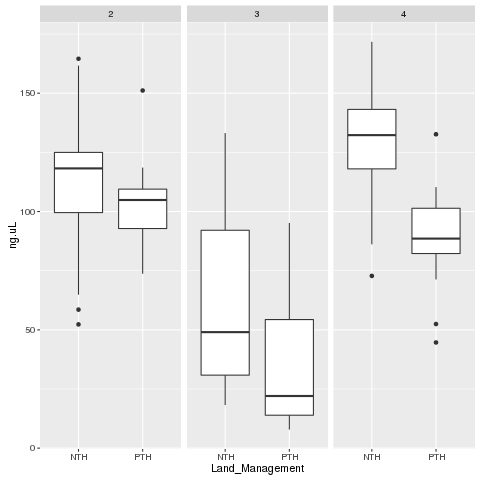

In [382]:
%%R
ggplot(DNA, aes(x = Land_Management, y = ng.uL)) + geom_boxplot()  + 
    facet_wrap(~Replicate)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘MASS’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:dplyr’:

    select


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: minpack.lm

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: rgl

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/r

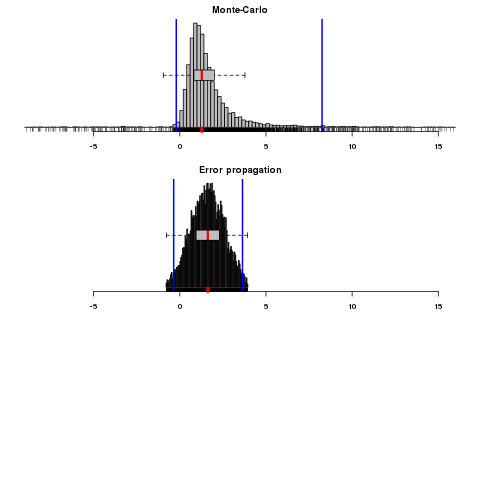

In [387]:
%%R
library(qpcR)
EXPR <- expression(x/y)
x <- c(100.48852, 43.72379)
y <- c(76.05044, 37.41768)
DF <- cbind(x, y)
RES1 <- propagate(expr = EXPR, data = DF, type = "stat", 
                 do.sim = TRUE, verbose = TRUE)

In [395]:
%%R
RES1$summary

                  Sim Perm       Prop
Mean        0.9352060  NaN  1.6412041
Std.dev.   50.6778569   NA  1.0187432
Median      1.2765574   NA         NA
MAD         0.8271194   NA         NA
Conf.lower -0.2048805   NA -0.3554958
Conf.upper  8.2556255   NA  3.6379040


## Following Response Groups

In [150]:
%%R
#Response groups
df.Cell = read.table('data/l2fc_sparse-maxRejH_FuncG_cellulose.txt', sep = '\t', header = TRUE)
df.Xyl = read.table('data/l2fc_sparse-maxRejH_FuncG_xylose.txt', sep = '\t', header = TRUE)

In [151]:
%%R
df.Cell.g3 = filter(df.Cell, func_group == 3 )
df.Cell.g24810 = filter(df.Cell, func_group %in% c(2,4,8,10))

df.Xyl.g589 = filter(df.Xyl, func_group %in% c(5,8,9))
df.Xyl.g7 = filter(df.Xyl, func_group == 7 )
df.Xyl.g3 = filter(df.Xyl, func_group == 3)


In [221]:
%%R 
## In Sept Bulk Soils
F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Sample_Date == '9/24/14') & 
                            (physeq.Bulk.m$Land_Management %in% c('NTH', 'PTH')),
                           physeq.Bulk)

physeq.Bulk = physeq.Bulk %>% transform_sample_counts(function(x) x/sum(x))

physeq.Bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21374 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21374 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21374 tips and 21373 internal nodes ]


In [222]:
%%R
mdf.Sept = psmelt(physeq.Bulk)

In [223]:
%%R
mdf.Sept = mdf.Sept %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

In [322]:
%%R

Bulk.Cell.g3 = filter(mdf.Sept, OTU %in% df.Cell.g3$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)
Bulk.Cell.g24810 = filter(mdf.Sept, OTU %in% df.Cell.g24810$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)

Bulk.Xyl.g589 = filter(mdf.Sept, OTU %in% df.Xyl.g589$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)
Bulk.Xyl.g7 = filter(mdf.Sept, OTU %in% df.Xyl.g7$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)

Bulk.Xyl.g3 = filter(mdf.Sept, OTU %in% df.Xyl.g3$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)

#length(unique(BulkSIP.d3.PTH$OTU))

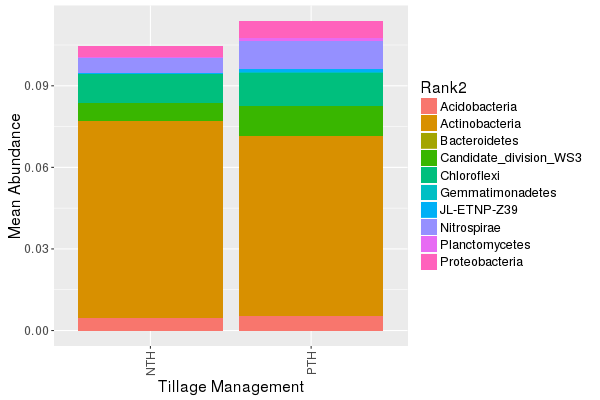

In [323]:
%%R -w 600 -h 400
Bulk.Cell.g3 =  Bulk.Cell.g3 %>%  group_by(Rank2, OTU, Land_Management) %>% 
        summarise(meanAb = mean(Abundance))


#Bulk.Cell.g3$Rank2 = factor(Bulk.Cell.g3$Rank2, levels= Bulk.Cell.g3$meanAb, ordered=TRUE)

#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Cell.g3) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') #+ guides(fill = FALSE) #+ scale_fill_manual(values = cols)

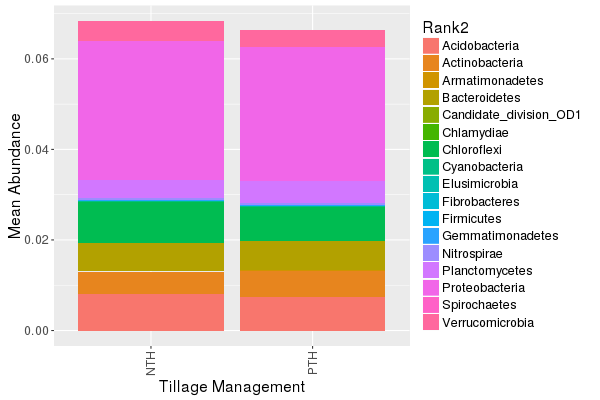

In [324]:
%%R -w 600 -h 400
Bulk.Cell.g24810 =  Bulk.Cell.g24810 %>% group_by(Rank2, OTU, Land_Management) %>% 
        summarise(meanAb = mean(Abundance))


#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Cell.g24810) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') #+ guides(fill = FALSE) #+ scale_fill_manual(values = cols)

In [242]:
%%R
Bulk.Cell.g24810 %>% group_by(Land_Management) %>% summarise(sum(meanAb))

Source: local data frame [2 x 2]

  Land_Management sum(meanAb)
           (fctr)       (dbl)
1             NTH 0.001627012
2             PTH 0.001525446


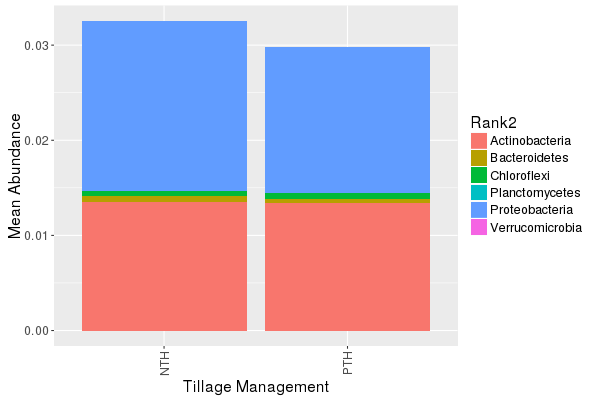

In [325]:
%%R -w 600 -h 400
Bulk.Xyl.g589 =  Bulk.Xyl.g589 %>% group_by(Rank2,OTU, Land_Management) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Xyl.g589) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') # + guides(fill = FALSE) #+ scale_fill_manual(values = cols)

In [250]:
%%R
Bulk.Xyl.g589 %>% group_by(Land_Management) %>% summarise(sum(meanAb))

Source: local data frame [2 x 2]

  Land_Management  sum(meanAb)
           (fctr)        (dbl)
1             NTH 0.0008298561
2             PTH 0.0008123171


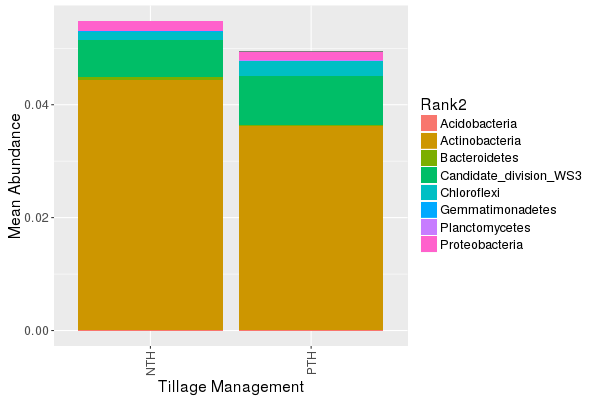

In [327]:
%%R -w 600 -h 400
Bulk.Xyl.g7 =  Bulk.Xyl.g7 %>% group_by(Rank2, OTU, Land_Management) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Xyl.g7) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') #+ guides(fill = FALSE) #+ scale_fill_manual(values = cols)

In [253]:
%%R
Bulk.Xyl.g7 %>% group_by(Land_Management) %>% summarise(sum(meanAb))

Source: local data frame [2 x 2]

  Land_Management sum(meanAb)
           (fctr)       (dbl)
1             NTH 0.002754444
2             PTH 0.002819113


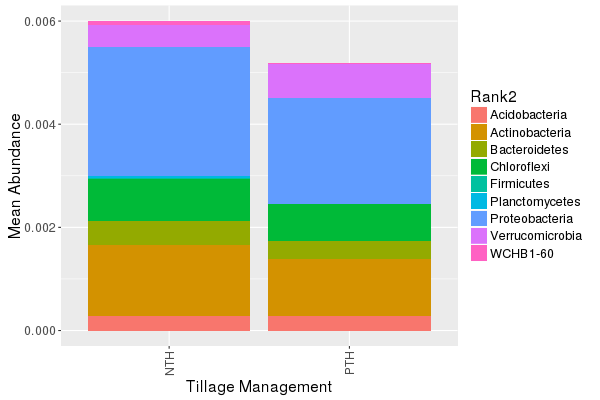

In [328]:
%%R -w 600 -h 400
Bulk.Xyl.g3 =  Bulk.Xyl.g3 %>% group_by(Rank2, OTU, Land_Management) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Xyl.g3) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance')# + guides(fill = FALSE) #+ scale_fill_manual(values = cols)

In [255]:
%%R
Bulk.Xyl.g3 %>% group_by(Land_Management) %>% summarise(sum(meanAb))

Source: local data frame [2 x 2]

  Land_Management sum(meanAb)
           (fctr)       (dbl)
1             NTH 0.001183479
2             PTH 0.001049252


## In BulkSIP Soil

In [265]:
%%R 
F = file.path(physeqDir, physeqBulkSIP)
physeq.BulkSIP = readRDS(F)
physeq.BulkSIP.m = physeq.BulkSIP %>% sample_data
physeq.BulkSIP = prune_samples((physeq.BulkSIP.m$Treatment != 'H2O') & 
                            (physeq.BulkSIP.m$Replicate ==4),
                           physeq.BulkSIP)

physeq.BulkSIP = physeq.BulkSIP %>% transform_sample_counts(function(x) x/sum(x))

physeq.BulkSIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16187 taxa and 26 samples ]
sample_data() Sample Data:       [ 26 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 16187 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16187 tips and 16186 internal nodes ]


In [266]:
%%R
mdf.BulkSIP = psmelt(physeq.BulkSIP) %>% mutate(Rank2 = gsub('^__', '', Rank2))

In [320]:
%%R

Bulk.Cell.g3 = filter(mdf.BulkSIP, OTU %in% df.Cell.g3$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)
Bulk.Cell.g24810 = filter(mdf.BulkSIP, OTU %in% df.Cell.g24810$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)

Bulk.Xyl.g589 = filter(mdf.BulkSIP, OTU %in% df.Xyl.g589$OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)
Bulk.Xyl.g7 = filter(mdf.BulkSIP, OTU %in% df.Xyl.g7 $OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)

Bulk.Xyl.g3 = filter(mdf.BulkSIP, OTU %in% df.Xyl.g3 $OTU) %>% dplyr::select(OTU, Abundance, Rank2, Day, Treatment, 
                                                                         Land_Management)

#length(unique(BulkSIP.d3.PTH$OTU))

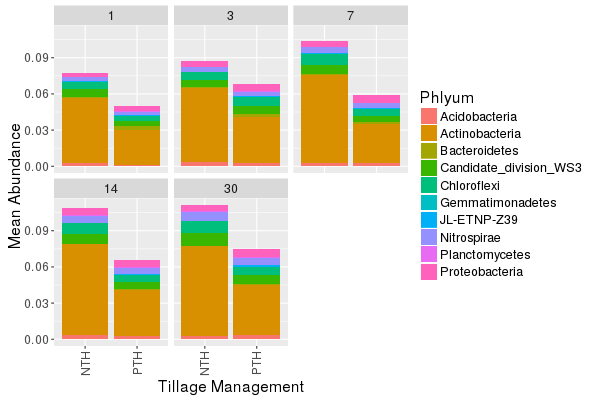

In [311]:
%%R -w 600 -h 400
Bulk.Cell.g3 =  Bulk.Cell.g3 %>%  group_by(Rank2, OTU, Land_Management, Day) %>% 
        summarise(meanAb = mean(Abundance))

#Bulk.Cell.g3$Rank2 = factor(Bulk.Cell.g3$Rank2, levels=Bulk.Cell.g3[order(Bulk.Cell.g3$meanAb), "Rank2"])


#Bulk.Cell.g3$Rank2 = factor(Bulk.Cell.g3$Rank2, levels= Bulk.Cell.g3$OTU, ordered=TRUE)

#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Cell.g3) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') + facet_wrap(~Day)+ 
        scale_fill_discrete(name = 'Phlyum')

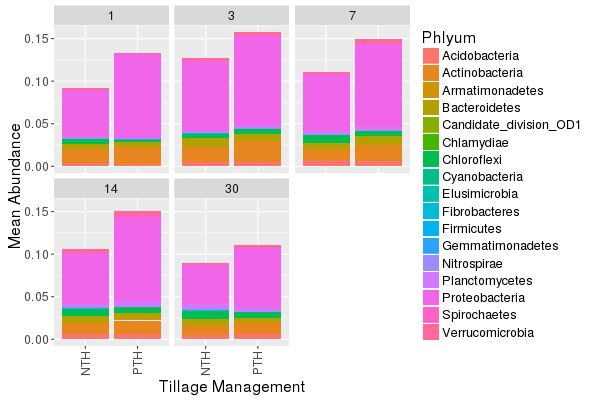

In [312]:
%%R -w 600 -h 400
Bulk.Cell.g24810 =  Bulk.Cell.g24810 %>% group_by(Rank2, OTU, Land_Management, Day) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Cell.g24810) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') + facet_wrap(~Day)+ 
        scale_fill_discrete(name = 'Phlyum')

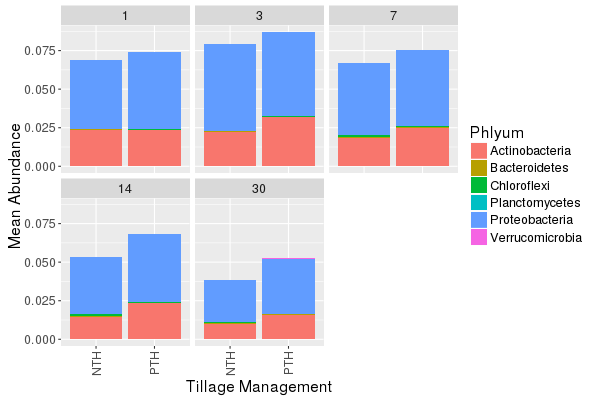

In [313]:
%%R -w 600 -h 400
Bulk.Xyl.g589 =  Bulk.Xyl.g589 %>% group_by(Rank2, OTU, Land_Management, Day) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Xyl.g589) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') + facet_wrap(~Day)+ 
        scale_fill_discrete(name = 'Phlyum')

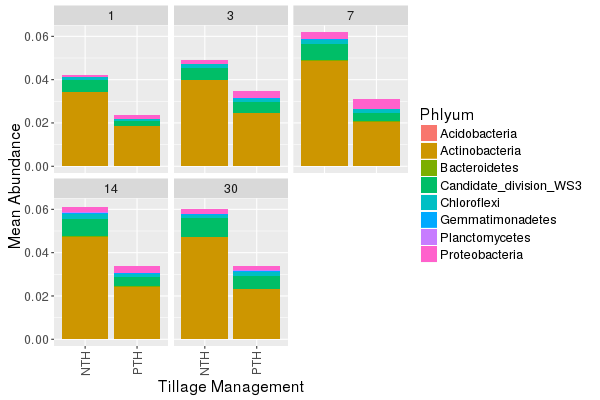

In [314]:
%%R -w 600 -h 400
Bulk.Xyl.g7 =  Bulk.Xyl.g7 %>% group_by(Rank2, OTU, Land_Management, Day) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Xyl.g7) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') + facet_wrap(~Day)+ 
        scale_fill_discrete(name = 'Phlyum')

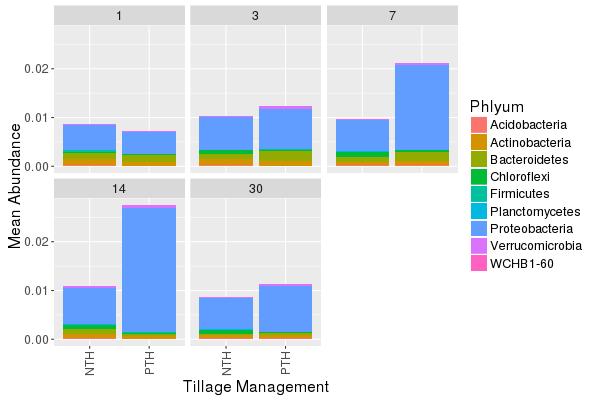

In [321]:
%%R -w 600 -h 400
Bulk.Xyl.g3 =  Bulk.Xyl.g3 %>% group_by(Rank2, OTU, Land_Management, Day) %>% 
        summarise(meanAb = mean(Abundance))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Bulk.Xyl.g3) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance') + facet_wrap(~Day) + 
        scale_fill_discrete(name = 'Phlyum')

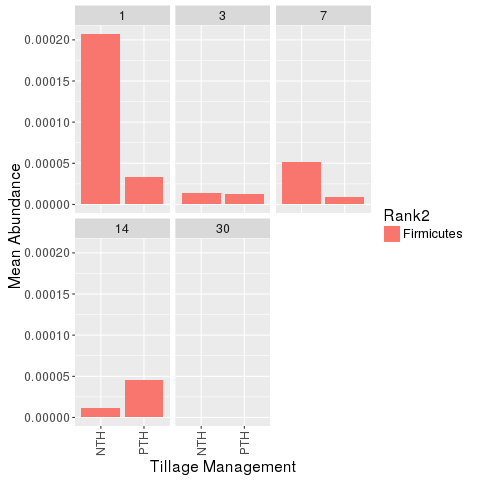

In [319]:
%%R
Firm = filter(Bulk.Xyl.g3, Rank2 == 'Firmicutes')
ggplot(Firm) + geom_bar(aes(Land_Management, meanAb, fill = Rank2), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Abundance')  + facet_wrap(~Day)

## Following Incorporators

In [8]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH.txt', sep='\t', header = TRUE)

In [10]:
%%R
Day3.PTH.Cell = filter(df.l2fc, Day == 3, Treatment == '13C', Land_Management == 'PTH', padj <=0.10)
Day3.NTH.Cell = filter(df.l2fc, Day == 3, Treatment == '13C', Land_Management == 'NTH', padj <=0.10)


Day1.PTH.Xyl = filter(df.l2fc, Day == 1, Treatment == '13X', Land_Management == 'PTH', padj <=0.10)
Day1.NTH.Xyl = filter(df.l2fc, Day == 1, Treatment == '13X', Land_Management == 'NTH', padj <=0.10)

print(length(Day3.PTH.Cell$OTU))
print(length(Day3.NTH.Cell$OTU))
print(length(Day1.PTH.Xyl$OTU))
print(length(Day1.NTH.Xyl$OTU))

[1] 185
[1] 17
[1] 161
[1] 127


In [28]:
%%R 

F = file.path(physeqDir, physeqBulkSIP)
physeq.BulkSIP = readRDS(F)
physeq.BulkSIP.m = physeq.BulkSIP %>% sample_data
physeq.BulkSIP = prune_samples(!(physeq.BulkSIP.m$Treatment %in% c("H2O", '12C')),
                           physeq.BulkSIP)

physeq.BulkSIP = physeq.BulkSIP %>% transform_sample_counts(function(x) x/sum(x))

physeq.BulkSIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16187 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 16187 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16187 tips and 16186 internal nodes ]


In [19]:
%%R
mdf = psmelt(physeq.BulkSIP)
mdf = mdf %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

In [452]:
%%R
mdf$Scaled_Ab <- ifelse(mdf$Land_Management == 'NTH', mdf$Abundance* 1.32 , mdf$Abundance)


In [453]:
%%R
BulkSIP.d3.PTH.Cell = filter(mdf, OTU %in% Day3.PTH.Cell$OTU) %>% dplyr::select(OTU, Abundance, Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d3.NTH.Cell = filter(mdf, OTU %in% Day3.NTH.Cell$OTU) %>% dplyr::select(OTU, Abundance, Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

BulkSIP.d1.PTH.Xyl = filter(mdf, OTU %in% Day1.PTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance, Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d1.NTH.Xyl = filter(mdf, OTU %in% Day1.NTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance, Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

#length(unique(BulkSIP.d3.PTH$OTU))

In [454]:
%%R
write.csv(BulkSIP.d3.PTH.Cell, file = 'data/BulkSIP.d3.PTH.Cell.csv')
write.csv(BulkSIP.d3.NTH.Cell, file = 'data/BulkSIP.d3.NTH.Cell.csv')

write.csv(BulkSIP.d1.PTH.Xyl, file = 'data/BulkSIP.d1.PTH.Xyl.csv')
write.csv(BulkSIP.d1.NTH.Xyl, file = 'data/BulkSIP.d1.NTH.Xyl.csv')

In [485]:
%%R
Cell.D3 = full_join(BulkSIP.d3.PTH.Cell, BulkSIP.d3.NTH.Cell) 

In [1]:
%%R
filter(Cell.D3, OTU == 'OTU.25', Treatment == '13C') %>% arrange(Land_Management)

ERROR: Cell magic `%%R` not found.


In [457]:
%%R
cols = c("#bc5e65",
"#6ab74c",
"#c350b7",
"#bdac46",
"#836bdb",
"#627c38",
"#d34178",
"#4eb596",
"#d25137",
"#6899d8",
"#c17f40",
"#6e5da6",
"#c578af")

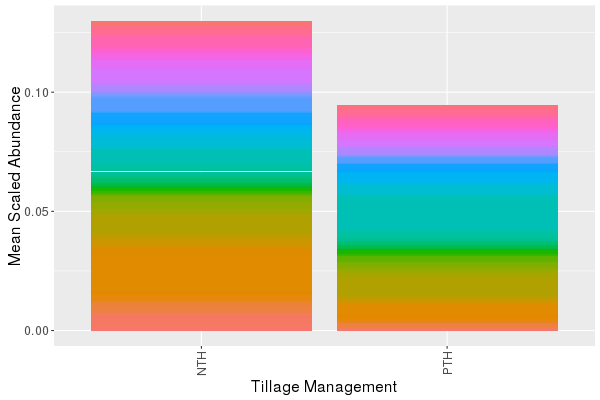

In [495]:
%%R -w 600 -h 400
Cell.D3.filt = filter(Cell.D3, Treatment == '13C', Day == 3, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Cell.D3.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
    #facet_wrap(~Rank2) + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + guides(fill = FALSE) #+ scale_fill_manual(values = cols)

In [500]:
%%R
Xyl.D1 = full_join(BulkSIP.d1.PTH.Xyl, BulkSIP.d1.NTH.Xyl)

In [460]:
%%R
xyl.cols = c("#d49023",
"#396ced",
"#afc52e",
"#9a41bd",
"#52bf48",
"#d73bab",
"#5ad080",
"#a26fe9",
"#c2b41d",
"#5f4fba",
"#80b239",
"#d86fd9",
"#398c2c",
"#827ae6",
"#d3ac2f",
"#3c66c4",
"#e37e21",
"#618bed",
"#b9b946",
"#8f479f",
"#4ea55f",
"#e3397d",
"#44c2a5",
"#e7424a",
"#3bbcc3",
"#d5471e",
"#54bce6",
"#b7302b",
"#559dd3",
"#ea7048",
"#598bd2",
"#d9ab4e",
"#6a5198",
"#868c26",
"#b34197",
"#54782d",
"#e656a2",
"#71ba8d",
"#d73b5f",
"#317d58",
"#aa2e6a",
"#a3b96f",
"#b180d4",
"#9d7b2c",
"#8171ba",
"#e19053",
"#43659e",
"#a54619",
"#a5a1e2",
"#ac6328",
"#db98de",
"#818445",
"#dd84b9",
"#786027",
"#9f6195",
"#cea86e",
"#8a4768",
"#e29478",
"#b85983",
"#a05940",
"#dd6b88",
"#b34545",
"#e38d9b",
"#9e4355",
"#e5726b")

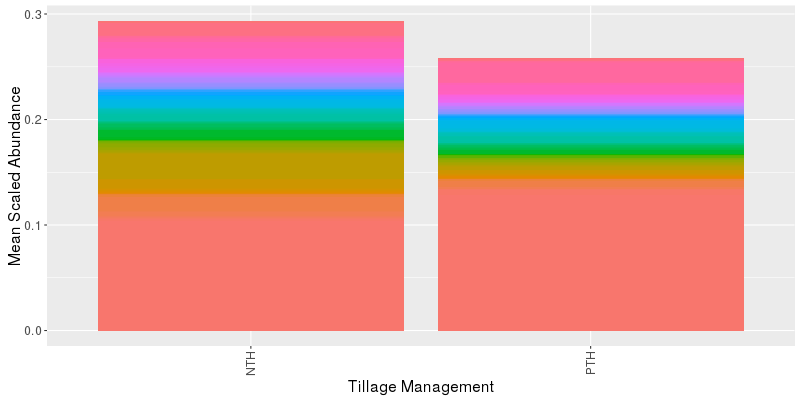

In [501]:
%%R -w 800 -h 400
Xyl.D1.filt = filter(Xyl.D1, Treatment == '13X', Day == 1, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))
Xyl.D1.top20 = Xyl.D1.filt %>% ungroup %>% top_n(20, wt = meanAb)

ggplot(Xyl.D1.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
    #facet_wrap(~Rank2, ncol = 4)  + theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + #scale_fill_manual(values = xyl.cols) + 
        guides(fill = FALSE)

### Looking at last day (14 and 30)

In [497]:
%%R
Day30.PTH.Cell = filter(df.l2fc, Day == 30, Treatment == '13C', Land_Management == 'PTH', padj <=0.10)
Day30.NTH.Cell = filter(df.l2fc, Day == 30, Treatment == '13C', Land_Management == 'NTH', padj <=0.10)


Day14.PTH.Xyl = filter(df.l2fc, Day == 14, Treatment == '13X', Land_Management == 'PTH', padj <=0.10)
Day14.NTH.Xyl = filter(df.l2fc, Day == 14, Treatment == '13X', Land_Management == 'NTH', padj <=0.10)

print(length(Day30.PTH.Cell$OTU))
print(length(Day30.NTH.Cell$OTU))
print(length(Day14.PTH.Xyl$OTU))
print(length(Day14.NTH.Xyl$OTU))

[1] 623
[1] 728
[1] 303
[1] 356


In [498]:
%%R
BulkSIP.d30.PTH.Cell = filter(mdf, OTU %in% Day30.PTH.Cell$OTU) %>% dplyr::select(OTU, Abundance, Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d30.NTH.Cell = filter(mdf, OTU %in% Day30.NTH.Cell$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

BulkSIP.d14.PTH.Xyl = filter(mdf, OTU %in% Day14.PTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d14.NTH.Xyl = filter(mdf, OTU %in% Day14.NTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

#length(unique(BulkSIP.d3.PTH$OTU))

In [464]:
%%R
write.csv(BulkSIP.d30.PTH.Cell, file = 'data/BulkSIP.d30.PTH.Cell.csv')
write.csv(BulkSIP.d30.NTH.Cell, file = 'data/BulkSIP.d30.NTH.Cell.csv')

write.csv(BulkSIP.d14.PTH.Xyl, file = 'data/BulkSIP.d14.PTH.Xyl.csv')
write.csv(BulkSIP.d14.NTH.Xyl, file = 'data/BulkSIP.d14.NTH.Xyl.csv')

In [502]:
%%R
Cell.D30 = full_join(BulkSIP.d30.PTH.Cell, BulkSIP.d30.NTH.Cell) 

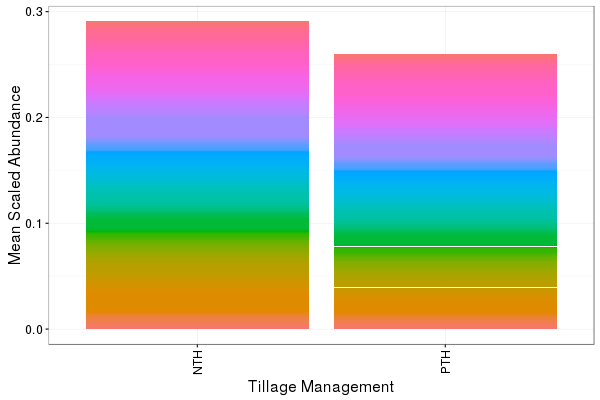

In [503]:
%%R -w 600 -h 400
Cell.D30.filt = filter(Cell.D30, Treatment == '13C', Day == 30, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Cell.D30.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
     theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + guides(fill = FALSE)

In [504]:
%%R
Xyl.D14 = full_join(BulkSIP.d14.PTH.Xyl, BulkSIP.d14.NTH.Xyl)

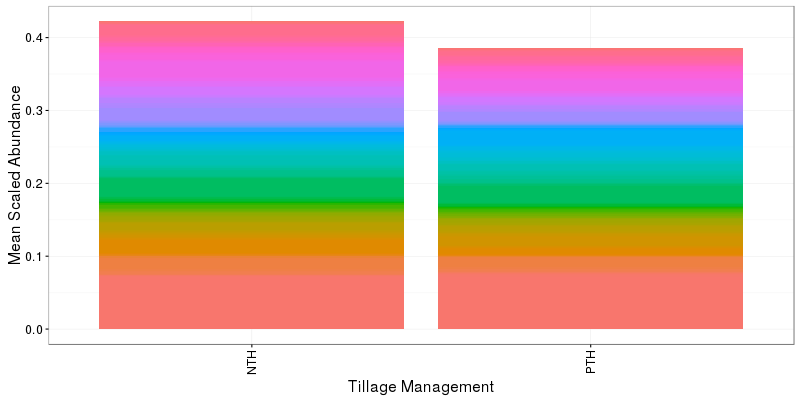

In [505]:
%%R -w 800 -h 400
Xyl.D14.filt = filter(Xyl.D14, Treatment == '13X', Day == 14, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))

ggplot(Xyl.D14.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') +
        guides(fill = FALSE)

## Middle Days

In [506]:
%%R
Day7.PTH.Cell = filter(df.l2fc, Day == 7, Treatment == '13C', Land_Management == 'PTH', padj <=0.10)
Day7.NTH.Cell = filter(df.l2fc, Day == 7, Treatment == '13C', Land_Management == 'NTH', padj <=0.10)


Day3.PTH.Xyl = filter(df.l2fc, Day == 3, Treatment == '13X', Land_Management == 'PTH', padj <=0.10)
Day3.NTH.Xyl = filter(df.l2fc, Day == 3, Treatment == '13X', Land_Management == 'NTH', padj <=0.10)

Day14.PTH.Cell = filter(df.l2fc, Day == 14, Treatment == '13C', Land_Management == 'PTH', padj <=0.10)
Day14.NTH.Cell = filter(df.l2fc, Day == 14, Treatment == '13C', Land_Management == 'NTH', padj <=0.10)


Day7.PTH.Xyl = filter(df.l2fc, Day == 7, Treatment == '13X', Land_Management == 'PTH', padj <=0.10)
Day7.NTH.Xyl = filter(df.l2fc, Day == 7, Treatment == '13X', Land_Management == 'NTH', padj <=0.10)


In [507]:
%%R
BulkSIP.d7.PTH.Cell = filter(mdf, OTU %in% Day7.PTH.Cell$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d7.NTH.Cell = filter(mdf, OTU %in% Day7.NTH.Cell$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

BulkSIP.d3.PTH.Xyl = filter(mdf, OTU %in% Day3.PTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d3.NTH.Xyl = filter(mdf, OTU %in% Day3.NTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

BulkSIP.d14.PTH.Cell = filter(mdf, OTU %in% Day14.PTH.Cell$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d14.NTH.Cell = filter(mdf, OTU %in% Day14.NTH.Cell$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

BulkSIP.d7.PTH.Xyl = filter(mdf, OTU %in% Day7.PTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)
BulkSIP.d7.NTH.Xyl = filter(mdf, OTU %in% Day7.NTH.Xyl$OTU) %>% dplyr::select(OTU, Abundance,Scaled_Ab, Rank2, Day, Treatment, 
                                                                         Land_Management)

#length(unique(BulkSIP.d3.PTH$OTU))

In [508]:
%%R
Cell.D7 = full_join(BulkSIP.d7.PTH.Cell, BulkSIP.d7.NTH.Cell) 

In [509]:
%%R
Cell.D14 = full_join(BulkSIP.d14.PTH.Cell, BulkSIP.d14.NTH.Cell) 

In [510]:
%%R
Xyl.D3 = full_join(BulkSIP.d3.PTH.Xyl, BulkSIP.d3.NTH.Xyl) 

In [511]:
%%R
Xyl.D7  = full_join(BulkSIP.d7.PTH.Xyl, BulkSIP.d7.NTH.Xyl) 

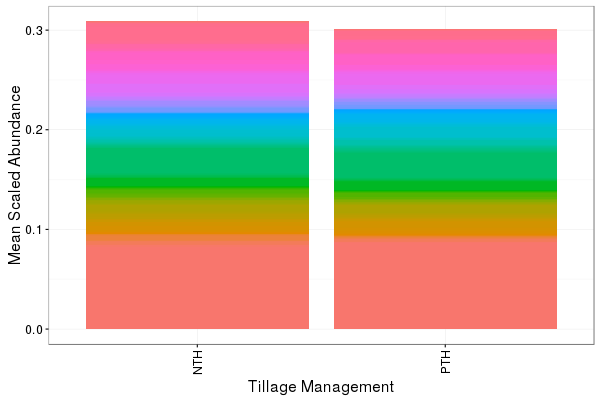

In [512]:
%%R -w 600 -h 400
Cell.D7.filt = filter(Cell.D7, Treatment == '13C', Day == 7, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Cell.D7.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
     theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + guides(fill = FALSE)

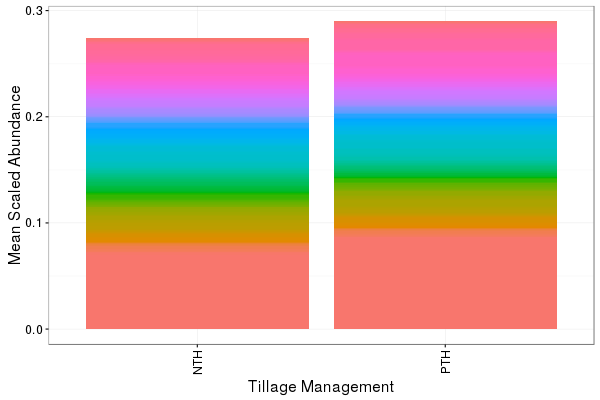

In [513]:
%%R -w 600 -h 400
Cell.D14.filt = filter(Cell.D14, Treatment == '13C', Day == 14, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Cell.D14.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
     theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + guides(fill = FALSE)

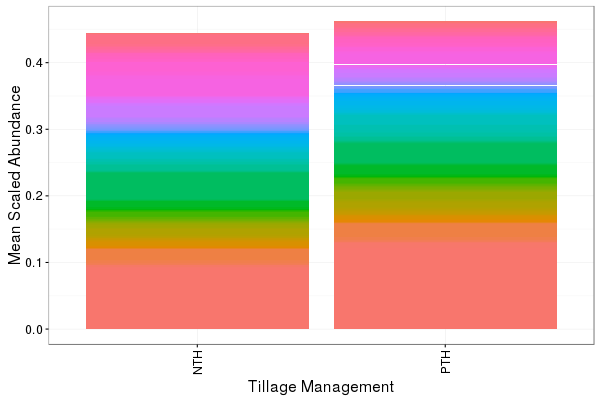

In [514]:
%%R -w 600 -h 400
Xyl.D3.filt = filter(Xyl.D3, Treatment == '13C', Day == 3, Scaled_Ab >0)%>% 
        group_by(OTU, Rank2, Land_Management) %>% 
        summarise(meanAb = mean(Scaled_Ab))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

ggplot(Xyl.D3.filt) + geom_bar(aes(Land_Management, meanAb, fill = OTU), stat = 'identity') +
     theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + guides(fill = FALSE)

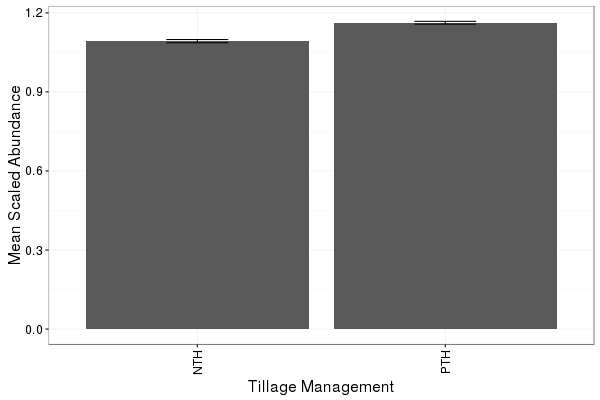

In [525]:
%%R -w 600 -h 400
Xyl.D7.filt = filter(Xyl.D7, Treatment == '13C', Day == 7, Scaled_Ab >0)%>% 
        group_by(Land_Management) %>% 
        summarise(sumAb = sum(Scaled_Ab), sd = sd(Scaled_Ab))
#Cell.D3.top20 = Cell.D3.filt %>% group_by(Land_Management) %>% top_n(10, wt = meanAb)

limits = aes(x = Land_Management, ymax = sumAb + sd, ymin= sumAb - sd)

ggplot(Xyl.D7.filt) + geom_bar(aes(Land_Management, sumAb), stat = 'identity') +
     theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        ) + xlab('Tillage Management') + ylab('Mean Scaled Abundance') + guides(fill = FALSE) +
        geom_errorbar(limits, width=0.25)